# IMPORTS AND SETUP

In [3]:

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.inspection import permutation_importance
from scipy.stats import chi2_contingency
import joblib

RANDOM_STATE = 42
sns.set(style="whitegrid")

# LOAD DATASET

In [5]:

DATA_PATH = "diabetes (1).csv"   # update if your CSV name differs
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
df.head()

Shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# QUICK EDA

In [6]:

display(df.info())
display(df.describe().T)
print("Outcome counts:\n", df['Outcome'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


None

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


Outcome counts:
 Outcome
0    500
1    268
Name: count, dtype: int64


# DATA CLEANING

In [7]:

cols_zero_missing = ["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]

df = df.copy()  # work on a copy
for c in cols_zero_missing:
    zeros = (df[c] == 0).sum()
    med_nonzero = df.loc[df[c] != 0, c].median()
    print(f"{c}: zeros={zeros}, median(non-zero)={med_nonzero}")
    df.loc[df[c] == 0, c] = np.nan
    df[c] = df[c].fillna(med_nonzero)

print("\nRemaining NaNs per column:")
print(df.isna().sum())

Glucose: zeros=5, median(non-zero)=117.0
BloodPressure: zeros=35, median(non-zero)=72.0
SkinThickness: zeros=227, median(non-zero)=29.0
Insulin: zeros=374, median(non-zero)=125.0
BMI: zeros=11, median(non-zero)=32.3

Remaining NaNs per column:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


# TARGET

In [8]:

FEATURES = ["Pregnancies","Glucose","BloodPressure","SkinThickness","Insulin","BMI","DiabetesPedigreeFunction","Age"]
TARGET = "Outcome"

X = df[FEATURES].copy()
y = df[TARGET].copy()
print("X shape:", X.shape, "y shape:", y.shape)

X shape: (768, 8) y shape: (768,)


# TEST SPLIT

In [9]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (614, 8) Test: (154, 8)


# BASELINE CV FOR BOTH MODELS|

In [10]:

pipe_lr = Pipeline([("scaler", StandardScaler()), ("clf", LogisticRegression(max_iter=5000, random_state=RANDOM_STATE))])
pipe_svm = Pipeline([("scaler", StandardScaler()), ("clf", SVC(probability=True, random_state=RANDOM_STATE))])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

cv_lr = cross_val_score(pipe_lr, X_train, y_train, cv=cv, scoring="accuracy")
cv_svm = cross_val_score(pipe_svm, X_train, y_train, cv=cv, scoring="accuracy")

print("LR CV accuracies:", np.round(cv_lr,4))
print("LR CV mean:", cv_lr.mean().round(4))
print("SVM CV accuracies:", np.round(cv_svm,4))
print("SVM CV mean:", cv_svm.mean().round(4))

LR CV accuracies: [0.7886 0.7805 0.8211 0.7805 0.7623]
LR CV mean: 0.7866
SVM CV accuracies: [0.7886 0.7805 0.7967 0.7642 0.7787]
SVM CV mean: 0.7818


# HYPERPARAMETER TUNING

In [11]:

param_grid_lr = {
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__penalty": ["l2"]
}

param_grid_svm = {
    "clf__C": [0.1, 1, 10],
    "clf__kernel": ["rbf", "linear"],
    "clf__gamma": ["scale", "auto"]
}

gs_lr = GridSearchCV(pipe_lr, param_grid_lr, cv=cv, scoring="accuracy", n_jobs=-1)
gs_svm = GridSearchCV(pipe_svm, param_grid_svm, cv=cv, scoring="accuracy", n_jobs=-1)

print("Fitting LR GridSearch...")
gs_lr.fit(X_train, y_train)
print("Best LR:", gs_lr.best_params_, "Best CV:", gs_lr.best_score_.round(4))

print("\nFitting SVM GridSearch...")
gs_svm.fit(X_train, y_train)
print("Best SVM:", gs_svm.best_params_, "Best CV:", gs_svm.best_score_.round(4))

Fitting LR GridSearch...
Best LR: {'clf__C': 1, 'clf__penalty': 'l2'} Best CV: 0.7866

Fitting SVM GridSearch...
Best SVM: {'clf__C': 1, 'clf__gamma': 'scale', 'clf__kernel': 'linear'} Best CV: 0.7882


# EVALUATE TUNED MODELS ON TEST SET

In [38]:

from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

best_lr = gs_lr.best_estimator_

y_pred = best_lr.predict(X_test_fe)
y_prob = best_lr.predict_proba(X_test_fe)[:, 1]

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("Test Accuracy:", round(acc, 4))
print("Test ROC-AUC:", round(auc, 4))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, digits=4))

Test Accuracy: 0.7013
Test ROC-AUC: 0.8204

Classification Report:

              precision    recall  f1-score   support

           0     0.7500    0.8100    0.7788       100
           1     0.5870    0.5000    0.5400        54

    accuracy                         0.7013       154
   macro avg     0.6685    0.6550    0.6594       154
weighted avg     0.6928    0.7013    0.6951       154



# COMPARISION TABLE

In [13]:

summary = pd.DataFrame([
    {"model":"LogisticRegression", "cv_mean":gs_lr.best_score_, "test_accuracy":res_lr["accuracy"], "test_auc":res_lr["roc_auc"]},
    {"model":"SVM", "cv_mean":gs_svm.best_score_, "test_accuracy":res_svm["accuracy"], "test_auc":res_svm["roc_auc"]}
])
display(summary.style.format({"cv_mean":"{:.4f}", "test_accuracy":"{:.4f}", "test_auc":"{:.4f}"}))

,model,cv_mean,test_accuracy,test_auc
0,LogisticRegression,0.7866,0.7078,0.8130
1,SVM,0.7882,0.7013,0.8131


# TRAINING ON FULL DATASET

In [36]:


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np
import joblib

RANDOM_STATE = 42

# Always use engineered features consistently
X_full = X_fe.copy()

print("Using X_fe as feature matrix")
print("Full data shape:", X_full.shape)

# Use best logistic estimator from GridSearch
final_lr = gs_lr.best_estimator_

# Fit on entire dataset
final_lr.fit(X_full, y)

# Cross-validation estimate (this is what you report)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_lr = cross_val_score(final_lr, X_full, y, cv=cv, scoring="accuracy", n_jobs=-1)

print("Logistic full-data CV mean:", np.round(cv_lr.mean(), 4))
print("CV folds:", np.round(cv_lr, 4))

# Save final deployment model
joblib.dump(final_lr, "final_model.pkl")
print("Saved final_model.pkl (Logistic trained on full dataset)")

Using X_fe as feature matrix
Full data shape: (768, 15)
Logistic full-data CV mean: 0.7708
CV folds: [0.7727 0.7987 0.7727 0.7582 0.7516]
Saved final_model.pkl (Logistic trained on full dataset)


# FINAL LOGISTIC

In [30]:

import joblib, os

# prefer in-memory final_lr, else try saved file
if 'final_lr' in globals():
    print("final_lr found in memory.")
else:
    if os.path.exists("final_model_lr_fulldata.pkl"):
        final_lr = joblib.load("final_model_lr_fulldata.pkl")
        print("Loaded final_lr from final_model_lr_fulldata.pkl")
    elif os.path.exists("final_model.pkl"):
        final_lr = joblib.load("final_model.pkl")
        print("Loaded final_lr from final_model.pkl (alias)")
    else:
        raise RuntimeError("final_lr not found in memory or disk. Make sure you ran the retrain-on-full-data step.")

final_lr found in memory.


# MINIMAL DIAGNNOSTICS ON FULL DATASET

Full-data (training fit) accuracy: 0.7786
Full-data (training fit) ROC-AUC:   0.8482

Classification report (full data):

              precision    recall  f1-score   support

           0     0.8022    0.8760    0.8375       500
           1     0.7207    0.5970    0.6531       268

    accuracy                         0.7786       768
   macro avg     0.7615    0.7365    0.7453       768
weighted avg     0.7738    0.7786    0.7731       768



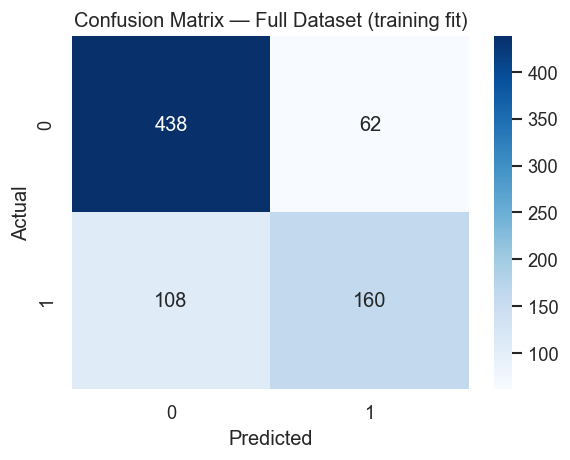

<Figure size 720x480 with 0 Axes>

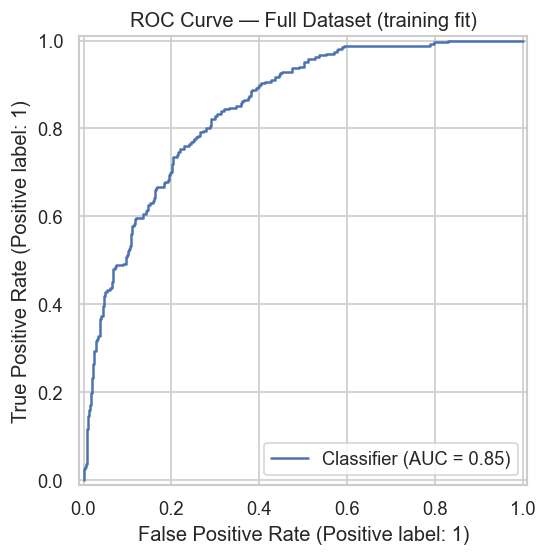

In [31]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, RocCurveDisplay

sns.set(style="whitegrid")
# X_full, y must exist per earlier cells; if not, reload your data and feature engineering.

# predictions & probs on full data
y_full_pred = final_lr.predict(X_full)
y_full_prob = final_lr.predict_proba(X_full)[:,1]

acc_full = (y_full_pred == y).mean()
auc_full = roc_auc_score(y, y_full_prob)

print(f"Full-data (training fit) accuracy: {acc_full:.4f}")
print(f"Full-data (training fit) ROC-AUC:   {auc_full:.4f}\n")
print("Classification report (full data):\n")
print(classification_report(y, y_full_pred, digits=4))

# confusion matrix plot
cm = confusion_matrix(y, y_full_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — Full Dataset (training fit)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig("confusion_matrix_full.png", dpi=150, bbox_inches='tight')
plt.show()

# ROC curve plot (and save)
plt.figure(figsize=(6,4))
RocCurveDisplay.from_predictions(y, y_full_prob)
plt.title("ROC Curve — Full Dataset (training fit)")
plt.tight_layout()
plt.savefig("roc_curve_full.png", dpi=150, bbox_inches='tight')
plt.show()

# SHOW AND SAVE LOGISTIC COEFFICIENTS

Glucose_log                 0.437422
Glucose                     0.416885
BMI_log                     0.322421
Pregnancies                 0.283127
Glucose_x_BMI               0.267256
Insulin_log                 0.261533
DiabetesPedigreeFunction    0.259719
Insulin                    -0.254268
Age_x_BMI                   0.153416
SkinThickness_log           0.134385
BloodPressure              -0.093844
SkinThickness              -0.081813
Preg_x_Glucose              0.078915
BMI                         0.056470
Age                         0.039975
dtype: float64

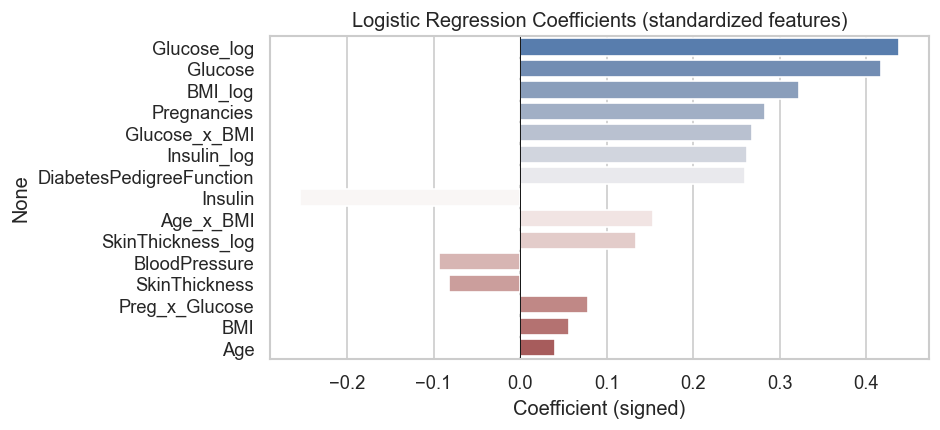

In [32]:

import pandas as pd
try:
    clf = final_lr.named_steps['clf']
    feat_names = X_full.columns.tolist()
    coefs = clf.coef_[0]
    coef_series = pd.Series(coefs, index=feat_names).sort_values(key=lambda s: abs(s), ascending=False)
    display(coef_series)

    # barplot and save
    plt.figure(figsize=(8, max(3, len(feat_names)*0.25)))
    sns.barplot(x=coef_series.values, y=coef_series.index, palette="vlag")
    plt.axvline(0, color='k', linewidth=0.6)
    plt.title("Logistic Regression Coefficients (standardized features)")
    plt.xlabel("Coefficient (signed)")
    plt.tight_layout()
    plt.savefig("lr_coefficients_full.png", dpi=150, bbox_inches='tight')
    plt.show()
except Exception as e:
    print("Could not extract coefficients:", e)

# SAVE THE FINAL MODEL

In [33]:

import joblib, os

joblib.dump(final_lr, "final_model.pkl")   # alias for the app
print("Saved alias: final_model.pkl -> logistic (trained on all data)")

# optional: remove SVM full-data artifact to avoid confusion
if os.path.exists("final_model_svm_fulldata.pkl"):
    try:
        os.remove("final_model_svm_fulldata.pkl")
        print("Removed final_model_svm_fulldata.pkl (you asked to drop SVM).")
    except Exception as e:
        print("Could not remove SVM file:", e)

Saved alias: final_model.pkl -> logistic (trained on all data)
Removed final_model_svm_fulldata.pkl (you asked to drop SVM).


In [17]:

from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

best_lr = gs_lr.best_estimator_
best_svm = gs_svm.best_estimator_

def eval_model(m, X_t, y_t, name):
    y_pred = m.predict(X_t)
    y_prob = m.predict_proba(X_t)[:,1] if hasattr(m, "predict_proba") else None
    acc = accuracy_score(y_t, y_pred)
    auc = roc_auc_score(y_t, y_prob) if y_prob is not None else None
    print(f"== {name} ==\nAccuracy: {acc:.4f}  ROC-AUC: {auc if auc is None else round(auc,4)}")
    print(classification_report(y_t, y_pred, digits=4))
    return acc, auc, y_pred, y_prob

res_lr = eval_model(best_lr, X_test_fe, y_test, "LR_tuned")
res_svm = eval_model(best_svm, X_test_fe, y_test, "SVM_tuned")

== LR_tuned ==
Accuracy: 0.7078  ROC-AUC: 0.8137
              precision    recall  f1-score   support

           0     0.7619    0.8000    0.7805       100
           1     0.5918    0.5370    0.5631        54

    accuracy                         0.7078       154
   macro avg     0.6769    0.6685    0.6718       154
weighted avg     0.7023    0.7078    0.7043       154

== SVM_tuned ==
Accuracy: 0.7078  ROC-AUC: 0.8143
              precision    recall  f1-score   support

           0     0.7477    0.8300    0.7867       100
           1     0.6047    0.4815    0.5361        54

    accuracy                         0.7078       154
   macro avg     0.6762    0.6557    0.6614       154
weighted avg     0.6976    0.7078    0.6988       154



In [18]:

import joblib
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import numpy as np
import pandas as pd

RANDOM_STATE = 42

# pick engineered features if available, else fall back to X
try:
    X_full = X_fe.copy()
    print("Using X_fe as feature matrix (engineered features).")
except NameError:
    X_full = X.copy()
    print("Using X as feature matrix (no extra engineered features found).")

# y must exist from earlier cells
print("Full data shape:", X_full.shape, "y shape:", y.shape)

# load best estimators from GridSearch objects if present, else create fresh pipelines
if 'gs_lr' in globals() and hasattr(gs_lr, 'best_estimator_'):
    final_lr = gs_lr.best_estimator_
    print("Using gs_lr.best_estimator_ for LogisticRegression pipeline.")
else:
    final_lr = Pipeline([("scaler", StandardScaler()), ("clf", LogisticRegression(max_iter=5000, random_state=RANDOM_STATE))])
    print("No gs_lr found — created default LogisticRegression pipeline.")

if 'gs_svm' in globals() and hasattr(gs_svm, 'best_estimator_'):
    final_svm = gs_svm.best_estimator_
    print("Using gs_svm.best_estimator_ for SVM pipeline.")
else:
    final_svm = Pipeline([("scaler", StandardScaler()), ("clf", SVC(probability=True, random_state=RANDOM_STATE))])
    print("No gs_svm found — created default SVM pipeline.")

# Fit both on entire dataset
print("\nFitting LogisticRegression on full dataset...")
final_lr.fit(X_full, y)
print("Fitting SVM on full dataset...")
final_svm.fit(X_full, y)

# Quick cross-validated estimate on full data (still useful)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
print("\nRunning 5-fold CV on full data (this re-evaluates generalization estimate):")
cv_lr = cross_val_score(final_lr, X_full, y, cv=cv, scoring="accuracy", n_jobs=-1)
cv_svm = cross_val_score(final_svm, X_full, y, cv=cv, scoring="accuracy", n_jobs=-1)
print("LR full-data CV mean:    ", np.round(cv_lr.mean(), 4), "  (folds: ", np.round(cv_lr,4), ")")
print("SVM full-data CV mean:   ", np.round(cv_svm.mean(), 4), "  (folds: ", np.round(cv_svm,4), ")")

# Save the retrained pipelines (for deployment)
joblib.dump(final_lr, "final_model_lr_fulldata.pkl")
joblib.dump(final_svm, "final_model_svm_fulldata.pkl")
# Also write the 'final_model.pkl' as alias to your chosen default (logistic here). Overwrite if you want SVM instead.
joblib.dump(final_lr, "final_model.pkl")

print("\nSaved models: final_model_lr_fulldata.pkl, final_model_svm_fulldata.pkl, (alias) final_model.pkl -> logistic")

# For presentation: show logistic coefficients (standardized space)
if hasattr(final_lr, "named_steps") and 'clf' in final_lr.named_steps:
    try:
        clf = final_lr.named_steps['clf']
        scaler = final_lr.named_steps.get('scaler', None)
        # If scaler exists, features are standardized — coefficients correspond to scaled features
        coefs = clf.coef_[0]
        feat_names = X_full.columns.tolist()
        coef_series = pd.Series(coefs, index=feat_names).sort_values(key=lambda s: np.abs(s), ascending=False)
        print("\nTop logistic coefficients (absolute value sorted) — standardized space:")
        display(coef_series)
    except Exception as e:
        print("Could not extract coefficients:", e)

# Small summary for slides
summary = pd.DataFrame([
    {"model":"LogisticRegression_full", "cv_mean":cv_lr.mean()},
    {"model":"SVM_full", "cv_mean":cv_svm.mean()}
])
display(summary.style.format({"cv_mean":"{:.4f}"}))

# Final note
print("\nNOTE: Training on full dataset removes a held-out test set. The CV mean above gives a robust estimate, but external validation on new data is still required for real-world claims.")

Using X_fe as feature matrix (engineered features).
Full data shape: (768, 15) y shape: (768,)
Using gs_lr.best_estimator_ for LogisticRegression pipeline.
Using gs_svm.best_estimator_ for SVM pipeline.

Fitting LogisticRegression on full dataset...
Fitting SVM on full dataset...

Running 5-fold CV on full data (this re-evaluates generalization estimate):
LR full-data CV mean:     0.7708   (folds:  [0.7727 0.7987 0.7727 0.7582 0.7516] )
SVM full-data CV mean:    0.7617   (folds:  [0.7597 0.7987 0.7468 0.7582 0.7451] )

Saved models: final_model_lr_fulldata.pkl, final_model_svm_fulldata.pkl, (alias) final_model.pkl -> logistic

Top logistic coefficients (absolute value sorted) — standardized space:


Glucose_log                 0.437422
Glucose                     0.416885
BMI_log                     0.322421
Pregnancies                 0.283127
Glucose_x_BMI               0.267256
Insulin_log                 0.261533
DiabetesPedigreeFunction    0.259719
Insulin                    -0.254268
Age_x_BMI                   0.153416
SkinThickness_log           0.134385
BloodPressure              -0.093844
SkinThickness              -0.081813
Preg_x_Glucose              0.078915
BMI                         0.056470
Age                         0.039975
dtype: float64

,model,cv_mean
0,LogisticRegression_full,0.7708
1,SVM_full,0.7617



NOTE: Training on full dataset removes a held-out test set. The CV mean above gives a robust estimate, but external validation on new data is still required for real-world claims.
